# Calculator of Risk to Terrestrial Carbon Pool

{bdg-link-warning}`Ongoing Development`

Primary Contact: [Dr. Vasilis Myrgiotis](https://www.ceh.ac.uk/staff/vasilis-myrgiotis)

````{card} Challenge:
The Terrestrial Carbon Pool refers to the total amount of carbon stored in terrestrial (land-based) ecosystems. It is a key component of the global carbon cycle and plays a central role in regulating atmospheric carbon dioxide (CO₂) levels. Key constituents include: vegetation, dead organic matter and soil organic matter. The size of the terrestrial carbon pool is influenced by factors such as land use, climate change, and natural disturbances (e.g., wildfires, pests). 

Accessing the relevant data and calculating the risk to the terrestrial carbon pool is one component of giving national and regional stakeholders (policy makers, charities, investors etc.) the right tools and information to make decisions about the implementation of Net Zero policies that balance land-based mitigation against other environmental, social and economic impacts, including the UN Sustainable Development Goals.
````

````{card} Approach:
This notebook describes and implements a "Risk to Terrestrial C Pool" data pipeline. The [Net Primary Production (NPP)](https://www.nature.com/scitable/knowledge/library/terrestrial-primary-production-fuel-for-life-17567411/) is the amount of carbon dioxide that is captured by plants through photosynthesis and converted into organic matter. It is used here to quantify the size of the terrestrial C pool and capture its patterns across space and time. 

The following steps are pefromed in the pipeline:
1. **Data Sourcing**: 
   - Download and prepare the data needed for the analysis.
   - This includes climate data (precipitation, temperature, VPD, etc.) and EO-based NPP data.
2. **Data Processing**: 
   - Calculate probability of drought, vulnerability of NPP to drought and risk posed by drought to NPP.
    - The user can select to use EO based soil moisture or the Standardized Precipitation-Evapotranspiration Index (SPEI) as the drought index
3. **Plot results**
````

```{admonition} Data Directory Creation:
:class: note, dropdown

The following directories will be created and files downloaded:
<li><strong>temp/</strong> (Temporary Files)<br>
This is your primary temporary directory, designed to hold all intermediate files generated during the processing steps.
</li>
<li><strong>temp/spei.nc</strong> (SPEI Data)<br>
You'll find the Standardized Precipitation Evapotranspiration Index (SPEI) data here. This is stored as a NetCDF file and provides a monthly time-series.
</li>
<li><strong>temp/SM/</strong> (Global Soil Moisture Data)<br>
This directory contains global soil moisture data. It's also in NetCDF format, but offers a weekly time-series, giving you more frequent updates on soil conditions.
</li>
<li><strong>temp/country_name/</strong> (Country-Specific EO Data)<br>
For each country you're working with, a dedicated subdirectory will be created here (e.g., temp/Kenya/, temp/South Africa/). These directories store the raw Earth Observation (EO) data downloaded for that specific country.
<ul>
    <li><strong>temp/country_name/country_name_merged_data.nc</strong> (Merged Country Data)<br>
        Inside each country_name/ directory, you'll find this crucial NetCDF file. This file represents the final, merged dataset for that country. It combines all the essential annual time-series data: Net Primary Productivity (NPP), Land Cover (LC), Soil Moisture (SM), and SPEI.
    </li>
```

```{contents}
:local:
```
<!-- https://jupyterbook.org/en/stable/structure/configure.html -->

## Import Libraries and Set Data Directory


A lot of the data for this tutorial is stored as NetCDF files, which is a common file format for gridded land-based data, such as climate and Earth Observation (EO) data. This type of data is handled efficiently by Xarray, a Python package designed for working with multi-dimensional arrays and datasets. The data is stored in a structured format that allows for easy access and manipulation of variables, dimensions, and attributes.

<div style="border: 2px solid #ffa500; background-color: #fffbe6; padding: 10px; border-radius: 6px; margin: 10px 0;">
    <strong>Note:</strong> <span style="color: #d35400;">Set the path to your home directory in the following block of code.</span>
</div>

In [79]:
## Importing packages and setting home directory path
homeDir = 'c:\\Users\\jercar\\OneDrive - UKCEH\\VSCode\\Jupyter_Books\\UKCEH_Data_Science_Book\\notebooks\\methods\\NCI_WP2A2\\data\\ncidata\\'

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.enums import Resampling
import warnings
warnings.filterwarnings("ignore")
import pygadm 
import folium as fl
import glob
import os
import datetime
import requests as r
import getpass, pprint, time, os, json
import urllib.request
from tqdm import tqdm

## Select Area of Interst 


In [17]:
## Select Country and level of Administrative Unit 
# africa_countries = list(pygadm.get_items(name='africa')['NAME_0'])
country_name = 'Morocco' # <-- Change this to the country you want to download
aoi = pygadm.Items(name=country_name, content_level=0) # content_level=0 for country, content_level=1 for admin level 1, content_level=2 for admin level 2

## Create and set the data directory (dataDir)
dataDir = os.path.join(homeDir, 'temp') 
os.makedirs(dataDir, exist_ok=True)

# Plot AOI to confirm it is correct
aoi = aoi.set_crs("EPSG:4326")
m = fl.Map(location=[aoi.geometry.centroid.y.mean(), aoi.geometry.centroid.x.mean()], zoom_start=6)
fl.GeoJson(aoi).add_to(m)
m

## Data Sourcing and Processing


### Land Cover (LC) and Net Primary Production (NPP) Data

These data are used to calculate the vulnerability of the terrestrial carbon pool to drought. The data are obtained from the [MODIS Land Cover product](https://lpdaac.usgs.gov/products/mcd12q1v006/) and [NPP product](https://lpdaac.usgs.gov/products/mod17a3hgfv006/). 

The data are downloaded from the NASA Earth Data website. The data are in netcdf format and are projected to the WGS84 coordinate system. The following block of code will download 50-200MB of data depending on the size of the selected country.

#### Downloading LC and NPP Data

<div style="border: 2px solid #ffa500; background-color: #fffbe6; padding: 10px; border-radius: 6px; margin: 10px 0;">
    <strong>Note:</strong> <span style="color: #d35400;">Please set up an account at <a href="https://urs.earthdata.nasa.gov/users/new?client_id=ZAQpxSrQNpk342OR77kisA&amp;redirect_uri=https%3A%2F%2Fappeears.earthdatacloud.nasa.gov%2Flogin&amp;response_type=code&amp;state=%2F" target="_blank">NASA Earthdata</a> before proceeding with running the following blocks of code. </span>
</div>

To get access to the data first we create a task in the NASA APEEARs system. When the task is submitted you will receive an email from "appeears-noreply@nasa.gov" with a link to monitor the progress - currently at https://appeears.earthdatacloud.nasa.gov/explore. The task may take a while to complete and the notebook could be closed/disconnected while this is going on, then once complete just skip to the downloading code block (Step 6) and enter the task ID from the email.

Steps 1-5 are only needed once to create and submit the data request to the NASA Earth Data website. In subsequent runs of the notebook skip to step 6 to download the data.

1. Authenticate with AρρEEARS API

In [18]:
### Step 1 : Authenticate with AρρEEARS API
# ----------------------------------------------------------------------
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable
user = getpass.getpass(prompt = 'Enter NASA Earthdata Login Username: ')      # Input NASA Earthdata Login Username
password = getpass.getpass(prompt = 'Enter NASA Earthdata Login Password: ')  # Input NASA Earthdata Login Password 
token_response = r.post('{}login'.format(api), auth=(user, password)).json()

2. Create a list for products to be requested

In [ ]:
### Step 2 : Create a list for products to be requested
# ----------------------------------------------------------------------
product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
prods = ['MOD17A3HGF.061']   # add first product to list
prods.append('MCD12Q1.061')  # add second product to list

### Create tupled list linking desired product with desired layers
layers = []
layers.append((prods[0],'Npp_500m')) # NPP at 500m resolution
layers.append((prods[0],'Npp_QC_500m')) # NPP quality control bits	
layers.append((prods[1],'LC_Type5')) # land cover type 5
layers.append((prods[1],'QC')) # land cover quality control bits

print(f'Product {products[prods[0]]}')

Product {'Product': 'MOD17A3HGF', 'Platform': 'Terra MODIS', 'Description': 'Net Primary Production (NPP) Gap-Filled', 'RasterType': 'Tile', 'Resolution': '500m', 'TemporalGranularity': 'Yearly', 'Version': '061', 'Available': True, 'DocLink': 'https://doi.org/10.5067/MODIS/MOD17A3HGF.061', 'Source': 'LP DAAC', 'TemporalExtentStart': '2000-02-18', 'TemporalExtentEnd': 'Present', 'Deleted': False, 'DOI': '10.5067/MODIS/MOD17A3HGF.061', 'Info': {}, 'ProductAndVersion': 'MOD17A3HGF.061'}


3. Define area of interest -- use the geometry of aoi produced previously

In [ ]:
### Step 3 : Define area of interest -- use the geometry of aoi produced previously
# ----------------------------------------------------------------------
nps = aoi.to_json() 
nps = json.loads(nps)   


4. Create a task request 

In [33]:
### Step 4 : Create a task request 
# ----------------------------------------------------------------------
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })
prodLayer

# task_name = input('Enter a Task Name: ') # User-defined name of the task: 'NPS Vegetation Area' used in example
task_name = f'{country_name}_NPP_LC' # Harcoded task name

projections = r.get('{}spatial/proj'.format(api)).json()  # Call to spatial API, return projs as json
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p  # Fill dictionary with `Name` as keys

task_type = ['point','area']        # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
startDate = '01-01-2000'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '12-31-2020'              # End of the date range for which to extract data: MM-DD-YYYY
recurring = False                   # Specify True for a recurring date range

task = {
    'task_type': task_type[1],
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat[1]}, 
                         'projection': proj},
         'geo': nps,
    }
}

5. Post json to the API task service and track progress

In [ ]:
### Step 5 : Post json to the API task service and track progress
# ----------------------------------------------------------------------
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json                                                                 # Print task responseget('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
task_id = task_response["task_id"]                                               # Set task id from request submission
tasks_response = r.get('{}task'.format(api), params=params, headers=head).json() # Query task service, setting params and header 
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials

starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])

6. Download the data

In [ ]:
## Step 6 : Download the data
# ----------------------------------------------------------------------
task_id = "7b552eda-27e3-4afc-9946-1b2049ccedf7" # Use the task_id from the previous step or the one you want to download
# Set up output directory as dataDir + 'EOdata'
EO_data_dir = os.path.join(dataDir, country_name, 'EO_data')  
if not os.path.exists(EO_data_dir):
    os.makedirs(EO_data_dir)  # Create the output directory if it does not exist
if not os.path.exists(EO_data_dir) : os.makedirs(EO_data_dir)     # Create the output directory

files = {}                                                       # Create empty dictionary
bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json                 
for f in bundle['files']: files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values

for f in files:
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f] 
    filepath = os.path.join(EO_data_dir, filename)                                                       # Create output file path
    with open(filepath, 'wb') as f:                                                                  # Write file to dest dir
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print('Downloaded files can be found at: {}'.format(EO_data_dir))

done
Downloaded files can be found at: c:\Users\jercar\OneDrive - UKCEH\VSCode\Jupyter_Books\UKCEH_Data_Science_Book\notebooks\methods\NCI_WP2A2\data\ncidata\temp/Morocco\EO_data


#### Reading and Plotting LC and NPP Data
Read the data. Set the CRS. Clip data to the area of interest:

In [35]:
EO_data_dir = os.path.join(dataDir,country_name,'EO_data')  
LC_ds = xr.open_dataset(f"{EO_data_dir}/MCD12Q1.061_500m_aid0001.nc")
NPP_ds = xr.open_dataset(f"{EO_data_dir}/MOD17A3HGF.061_500m_aid0001.nc")
LC_ds.rio.write_crs("epsg:4326", inplace=True)
NPP_ds.rio.write_crs("epsg:4326", inplace=True)
LC_ds = LC_ds.rio.clip([aoi.geometry.iloc[0]]) 
NPP_ds = NPP_ds.rio.clip([aoi.geometry.iloc[0]]) 

Plotting the Net Primary Production (NPP) data:

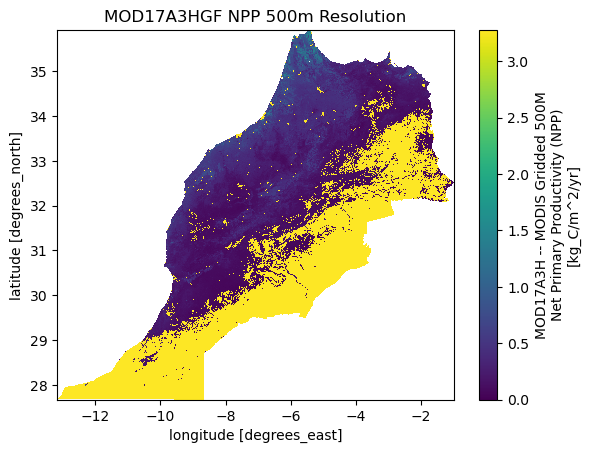

In [ ]:
NPP_ds['Npp_500m'].isel(time=0).plot.pcolormesh(cmap='viridis')
plt.title('MOD17A3HGF NPP 500m Resolution')
plt.show()

Plot the Land Cover (LC) data:

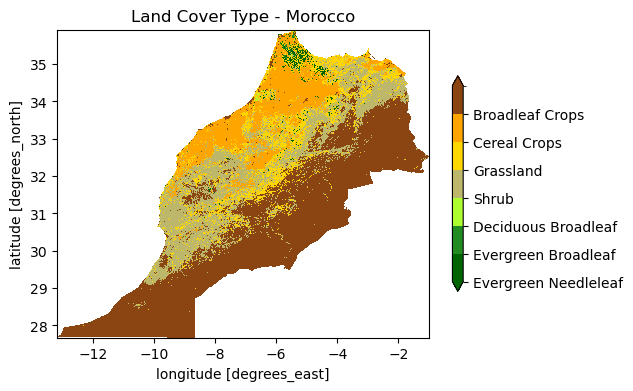

In [65]:
# Define land cover classes and colors (MODIS LC_Type5)
lc_group_values = [1, 2, 4, 5, 6, 7, 8]
lc_group_labels = [
    "Evergreen Needleleaf",
    "Evergreen Broadleaf",
    "Deciduous Broadleaf",
    "Shrub",
    "Grassland",
    "Cereal Crops",
    "Broadleaf Crops"   
]
lc_group_colors = [
    "#006400",  # dark green
    "#228B22",  # forest green
    "#ADFF2F",  # green yellow
    "#BDB76B",  # dark khaki
    "#FFD700",  # gold
    "#FFA500",  # orange
    "#8B4513"   # saddle brown
]

# Get unique classes present in the data
lc_unique = np.unique(LC_ds['LC_Type5'].isel(time=0).values)
lc_unique = lc_unique[~np.isnan(lc_unique)].astype(int)
lc_values_plot = [v for v in lc_group_values if v in lc_unique]
lc_labels_plot = [lc_group_labels[lc_group_values.index(v)] for v in lc_values_plot]
lc_colors_plot = [lc_group_colors[lc_group_values.index(v)] for v in lc_values_plot]

cmap_plot = ListedColormap(lc_colors_plot)
norm_plot = BoundaryNorm(lc_values_plot + [max(lc_values_plot)+1], cmap_plot.N)

fig, ax = plt.subplots(figsize=(6, 4))
im = LC_ds['LC_Type5'].isel(time=0).plot(
    ax=ax, x='lon', y='lat',
    cmap=cmap_plot, norm=norm_plot,
    cbar_kwargs={'ticks': lc_values_plot, 'shrink': 0.7, 'label': ''}
)
ax.set_title(f'Land Cover Type - {country_name}')
# Set tick labels
cbar = im.colorbar
cbar.set_ticks(lc_values_plot)
cbar.set_ticklabels(lc_labels_plot)
plt.show()

### Soil Moisture (SM) data

Soil Moisture data are obtained from the European Space Agency (ESA) Climate Change Initiative (CCI) Soil Moisture dataset. The data are in netcdf format, are projected to the WGS84 coordinate system and cover the entire world (thus, can be downloaded only once when implementing this algorithm for multiple countries). See [here](https://catalogue.ceda.ac.uk/uuid/dce27a397eaf47e797050c220972ca0e/) for more information on the dataset. The following block of code will download ~ 4.5GB of data. 

#### Downloading SM Data

In [ ]:
## Download data for each year between 2000 and 2020
SM_data_dir = os.path.join(dataDir,"SM_data")
os.makedirs(SM_data_dir, exist_ok=True)
if not os.path.exists(SM_data_dir) or not os.listdir(SM_data_dir):
    for year in tqdm(range(2001, 2020+1)):
        # Get all Mondays in the year (ISO week starts on Monday)
        d = datetime.date(year, 1, 1)
        d += datetime.timedelta(days=(0 - d.weekday()) % 7)  # first Monday
        while d.year == year:
            # Format date as YYYYMMDD
            date_str = d.strftime('%Y%m%d')
            # Construct the filename pattern (adjust as needed for actual filenames)
            nc_filename = f"ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-{date_str}000000-fv09.1.nc"
            url = f"ftp://anon-ftp.ceda.ac.uk/neodc/esacci/soil_moisture/data/daily_files/COMBINED/v09.1/{year}/{nc_filename}"
            # Download directly into the target directory, no subdirs
            urllib.request.urlretrieve(url, os.path.join(SM_data_dir,nc_filename))
            d += datetime.timedelta(days=7)
else:
    print(f"SM data already exists in {SM_data_dir}, skipping download.")

ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010101000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010108000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010115000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010122000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010129000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010205000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010212000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010219000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010226000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010305000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010312000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010319000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010326000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010402000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010409000000-fv09.1.nc
ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20010416000000-fv

#### Reading and Plotting SM Data
Read soil moisture data. Resample to monthly-then-annual frequency. Clip to the area of interest.

In [67]:
# Find all NetCDF files in the directory
SM_data_dir = os.path.join(dataDir,"SM_data") 
nc_files = sorted(glob.glob(os.path.join(SM_data_dir, '*.nc')))

# Open and combine all NetCDF files along the 'time' dimension (change as needed)
cci_sm = xr.open_mfdataset(nc_files, chunks="auto", combine='by_coords')
cci_sm.rio.write_crs("epsg:4326", inplace=True)

## Resample to monthly mean
cci_sm_monthly = cci_sm.resample(time='1M').mean(dim='time', skipna=True)

## Clip area of interst 
cci_sm_monthly = cci_sm_monthly.rio.clip([aoi.geometry.iloc[0]])

## Group by month and calculate the mean and std for each calendar month across all years
sm_clim_mean = cci_sm_monthly.groupby('time.month').mean(dim='time')
sm_clim_std = cci_sm_monthly.groupby('time.month').std(dim='time')

"""Calculate the monthly anomalies
- Soil Moisture Anomaly = (Current SM − Mean SM) / Standard Deviation of SM
- Large negative values (e.g., below -1 or -2 standard deviations) often signify drought
"""
cci_sm_monthly['sm_anomaly'] = ((cci_sm_monthly['sm'] - sm_clim_mean['sm'].sel(month=cci_sm['time.month'])) 
                                / sm_clim_std['sm'].sel(month=cci_sm['time.month']))

## Reproject and transpose to match the NPP and LC data
cci_sm_annual = cci_sm_monthly.resample(time='Y').mean(dim='time',skipna=True)
SM_ds = cci_sm_annual.rio.reproject('EPSG:4326', shape=(int(NPP_ds.lat.shape[0]), int(NPP_ds.lon.shape[0])), 
                                    resampling=Resampling.bilinear, nodata=np.nan)

SM_ds = SM_ds.transpose('time', 'y', 'x')
SM_ds = SM_ds.rename({'y': 'lat', 'x': 'lon'})
SM_ds = SM_ds.sel(time=slice('2001','2020'))
SM_ds = SM_ds.assign_coords(lat=LC_ds.lat, lon=LC_ds.lon, time=LC_ds.time)

Plotting the soil moisture data:

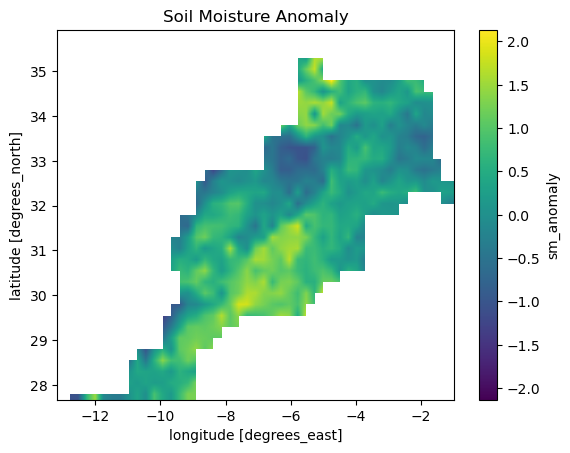

In [ ]:
SM_ds.sm_anomaly.isel(time=0).plot.pcolormesh(cmap='viridis')
plt.title('Soil Moisture Anomaly')
plt.show()

### Standardized Precipitation-Evapotranspiration Index (SPEI) Data

The following code downloads the pre-calculated SPEI data from the [SPEI database](https://spei.csic.es/database.html). The data are in netcdf format, are projected to the WGS84 coordinate system and cover the entire world (thus, can be downloaded only once when implementing this algorithm for multiple countries).

#### Downloading SPEI Data

In [10]:
## Define working directory and SPEI file path
spei_url = "https://spei.csic.es/spei_database/nc/spei12.nc"
spei_path = os.path.join(dataDir, "spei12.nc")
## Download if not already present
if not os.path.exists(spei_path):
    # Use quotes around the path to handle spaces
    urllib.request.urlretrieve(spei_url, spei_path)
    # os.system(f"wget -O \"{spei_path}\" \"{spei_url}\"")

#### Reading and Plotting SPEI Data

Reading SPEI data:

In [69]:
## Load and process 
SPEI = xr.open_dataset(spei_path)
SPEI.rio.write_crs("epsg:4326", inplace=True)
SPEI = SPEI.rio.clip([aoi.geometry.iloc[0]]) 
SPEI = SPEI.sel(time=slice('2001','2020'))
SPEI = SPEI.rio.reproject('EPSG:4326', shape=(int(NPP_ds.lat.shape[0]), int(NPP_ds.lon.shape[0])), 
                          resampling=Resampling.bilinear, nodata=np.nan)
## Resample the 'spei' variable in SPEI to annual mean
SPEI_annual = SPEI.resample(time='1Y').mean()
SPEI_annual = SPEI_annual.rename({'x':'lon','y':'lat'})
SPEI_annual['time'] = NPP_ds['time']

Plotting the SPEI data:

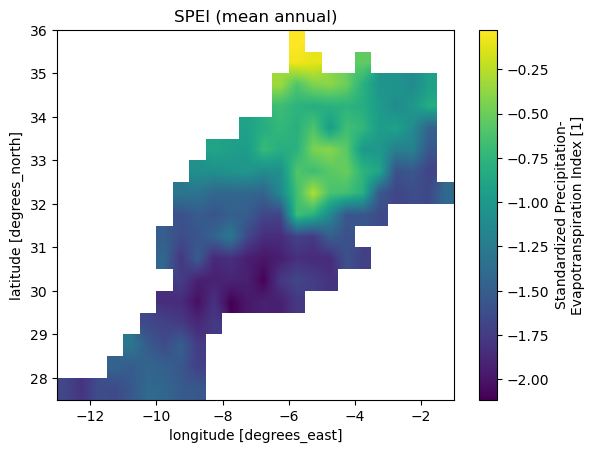

In [ ]:
SPEI_annual.spei.isel(time=0).plot.pcolormesh(cmap='viridis')
plt.title('SPEI (mean annual)')
plt.show()

### Merging Data 

The NPP, LC, Soil Moisture and SPEI data are merged into a single dataset. The dataset is saved as a netcdf file. The resulting netcdf file will vary in size depending on the size of the selected country and can take up to 10GB of space.

In [71]:
## Merge the datasets
ds = xr.merge(objects=[LC_ds.LC_Type5,
                       NPP_ds.Npp_500m,
                       SPEI_annual.spei,
                       SM_ds.sm_anomaly], 
              join="override",compat="override",combine_attrs="drop_conflicts")

## Mask water bodies, baren and urban areas out 
ds_masked = ds.where(~ds.LC_Type5.isin([0,9,10,11,255]))

## kg C m-2 yr-1 --> t C ha-1 yr-1
ds_masked['Npp_500m'] = ds_masked['Npp_500m'] * 10 

## Save the merged dataset to a NetCDF file
# Ensure the directory exists and handle spaces in the path
output_path = os.path.join(dataDir,country_name,f"{country_name}_merged_data.nc")
ds_masked.to_netcdf(output_path, mode='w', format='NETCDF4')

## Calculate Risk to Terrestrial C Pool

Risk calculation is performed using the approach presented in [van Oijen et al 2013](https://iopscience.iop.org/article/10.1088/1748-9326/8/1/015032) where the risk is defined as the probability of drought multiplied by the vulnerability of NPP to drought.

The user can choose (1st line in code block below) the drought metric to use for the risk calculation: 1. the Standardized Precipitation-Evapotranspiration Index (SPEI) or 2. the Soil Moisture data.

In [72]:
droughtMetric = 'spei' # sm_anomaly or spei
ds_masked['limit'] = np.nanpercentile(np.array(ds_masked[droughtMetric].data),25) # -1  # np.nanpercentile(data.spei,50)
ds_masked['NPP_non_haz'] = ds_masked.Npp_500m.where(ds_masked[droughtMetric] >= ds_masked['limit']).mean(dim='time', skipna=True)
ds_masked['NPP_haz'] = ds_masked.Npp_500m.where(ds_masked[droughtMetric] < ds_masked['limit']).mean(dim='time', skipna=True)
ds_masked['NPP_vuln'] = ds_masked['NPP_non_haz'] - ds_masked['NPP_haz']
ds_masked['NPP_prob'] = (ds_masked[droughtMetric] < ds_masked['limit']).sum(dim='time') / len(ds_masked.time)
ds_masked['NPP_risk'] = ds_masked['NPP_vuln'] * ds_masked['NPP_prob']
ds_masked['NPP_risk'] = ds_masked['NPP_risk'].where(ds_masked['NPP_risk'] > 0, 0)

## Plotting Input Data and Risk to Terrestrial C Pool


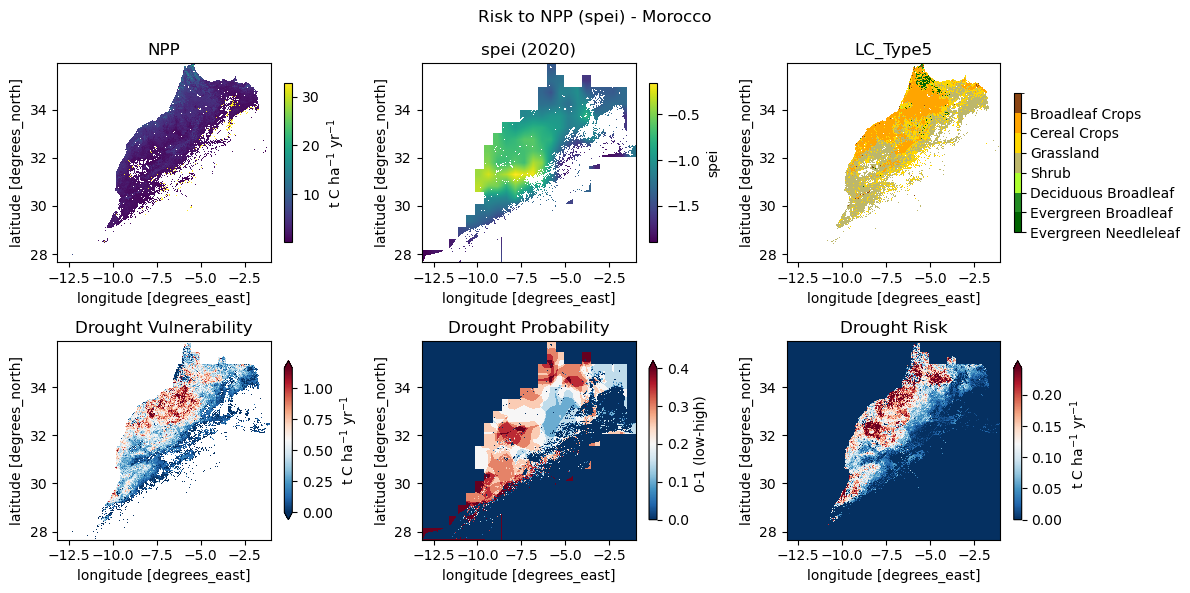

In [73]:
### PLOTTING FOR NPP 
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Plot NPP 
ds_masked['Npp_500m'].isel(time=0).plot(ax=axs[0, 0], x='lon', y='lat', cbar_kwargs={'label': r't C ha$^{-1}$ yr$^{-1}$', 'shrink': 0.8})
axs[0, 0].set_title('NPP')

# Plot droughtMetric 
ds_masked[droughtMetric].isel(time=-1).plot(ax=axs[0, 1], x='lon', y='lat', cbar_kwargs={'label': droughtMetric, 'shrink': 0.8})
axs[0, 1].set_title(droughtMetric + ' (2020)')

# Only plot classes present in the data
lc_group_values = [1, 2, 4, 5, 6, 7, 8]
lc_group_labels = [
        "Evergreen Needleleaf",
        "Evergreen Broadleaf",
        "Deciduous Broadleaf",
        "Shrub",
        "Grassland",
        "Cereal Crops",
        "Broadleaf Crops"        
]
lc_group_colors = [
    "#006400",  # dark green
    "#228B22",  # forest green
    "#ADFF2F",  # green yellow
    "#BDB76B",  # dark khaki
    "#FFD700",  # gold
    "#FFA500",  # orange
    "#8B4513"   # saddle brown
]

lc_unique = np.unique(ds_masked['LC_Type5'].isel(time=0).values)
lc_unique = lc_unique[~np.isnan(lc_unique)].astype(int)
lc_values_plot = [v for v in lc_group_values if v in lc_unique]
lc_labels_plot = [lc_group_labels[lc_group_values.index(v)] for v in lc_values_plot]
lc_colors_plot = [lc_group_colors[lc_group_values.index(v)] for v in lc_values_plot]

cmap_plot = ListedColormap(lc_colors_plot)
norm_plot = BoundaryNorm(lc_values_plot + [max(lc_values_plot)+1], cmap_plot.N)

im_lc = ds_masked['LC_Type5'].isel(time=0).plot(
    ax=axs[0, 2], x='lon', y='lat', 
    cmap=cmap_plot, norm=norm_plot,
    cbar_kwargs={'ticks': lc_values_plot, 'shrink': 0.7, 'label': ''},  # Remove label here
)
axs[0, 2].set_title('LC_Type5')
# Set tick labels
cbar = im_lc.colorbar
cbar.set_ticks(lc_values_plot)
cbar.set_ticklabels(lc_labels_plot)

# Plot NPP Vulnerability
im = ds_masked['NPP_vuln'].plot(ax=axs[1, 0], x='lon', y='lat', 
    vmin=0, vmax=np.nanpercentile(ds_masked['NPP_vuln'], 99), 
    cmap='RdBu_r',
    cbar_kwargs={'label': r't C ha$^{-1}$ yr$^{-1}$', 'shrink': 0.8}
)
axs[1, 0].set_title('Drought Vulnerability')

# Plot Probability
im = ds_masked['NPP_prob'].plot(ax=axs[1, 1], x='lon', y='lat', 
    vmin=0, vmax=np.nanpercentile(ds_masked['NPP_prob'], 99), 
    cmap='RdBu_r', cbar_kwargs={'label': '0-1 (low-high)', 'shrink': 0.8})
axs[1, 1].set_title('Drought Probability')

# Plot NPP Risk
im = ds_masked['NPP_risk'].plot(
    ax=axs[1, 2], x='lon', y='lat',
    vmin=0, vmax=np.nanpercentile(ds_masked['NPP_risk'], 99),
    cmap='RdBu_r',
    cbar_kwargs={'label': r't C ha$^{-1}$ yr$^{-1}$', 'shrink': 0.8}
)
axs[1, 2].set_title('Drought Risk')

fig.suptitle(f'Risk to NPP ({droughtMetric}) - {country_name}', fontsize=12)
plt.tight_layout()
plt.show()